In [54]:
#Importo librerie utili al programma
import numpy as np
import random as rd
import math as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import csv
import seaborn as sns

In [55]:
#Variabili utili al programma
steps=100
birds=100
b=0.5
ndim=3
view_step=steps-1

Quantificazione dell'anisotropia dello stormo:
![Anisotropia](anisotropia.png)

In [56]:
def anisotropia(vel,pos):
    position=pos
    veloc=vel
    mini=200
    matrix=np.zeros((birds,3,3))
    for i in range(birds):
        for j in range(birds):
            if i != j:
                val=np.linalg.norm(position[i]-position[j])
                if val < mini:
                    j1=j
                    mini=val
        ui=(veloc[i]/np.linalg.norm(veloc[i]))
        uj=(veloc[j1]/np.linalg.norm(veloc[j1]))
        matrix[i][0][0]=ui[0]*uj[0]
        matrix[i][0][1]=ui[0]*uj[1]
        matrix[i][0][2]=ui[0]*uj[2]
        matrix[i][1][0]=ui[1]*uj[0]
        matrix[i][1][1]=ui[1]*uj[1]
        matrix[i][1][2]=ui[1]*uj[2]
        matrix[i][2][0]=ui[2]*uj[0]
        matrix[i][2][1]=ui[2]*uj[1]
        matrix[i][2][2]=ui[2]*uj[2]
        mini=200

    Mmedio=np.mean(matrix,axis=0)
    autovalori, autovettori = np.linalg.eig(Mmedio)
    low=min(autovalori)
    index,=np.where(autovalori==low)
    autovet=autovettori[index,:]
    vet=autovet/np.linalg.norm(autovet)
    gamma=pow(vet[0][0]*VelNorm[0]+vet[0][1]*VelNorm[1]+vet[0][2]*VelNorm[2],2)
    return gamma

Funzioni per calcolare la velocità media, polarizzazione e recuperare la velocità e la posizione di un uccello ad uno step dato in input

In [57]:
def vel_media_at_step(step,file_vel_tot):
    velstep=vel_at_step(step,file_vel_tot)
    v_mean=np.mean(velstep,axis=0)
    return v_mean

In [58]:
def polarization_at_step(step,file_vel_tot):
    #array=np.zeros((birds,ndim))
    arr = np.zeros(ndim)
    for j in range (birds):
        #norm = np.linalg.norm(vel_at_step(step,file_vel_tot)[j])
        #array[j] = vel_at_step(view_step,file_vel_tot)[j] / norm
        arr+=vel_at_step(step,file_vel_tot)[j]/np.linalg.norm(vel_at_step(step,file_vel_tot)[j])
    #pol=np.linalg.norm(np.mean(array,axis=0))
    pol = np.linalg.norm(arr / birds)
    return pol

In [59]:
def vel_at_step(a,file_vel_tot):
    cont= a * birds
    i=0
    data_vel = np.zeros((birds, 3))
    fine=cont+birds

    while cont < (fine):
       data_vel[i]=file_vel_tot[cont]
       cont+=1
       i+=1
    return data_vel

In [60]:
def pos_at_step(a,file_pos_tot):
    cont= a * birds
    i=0
    data_pos = np.zeros((birds, 3))
    fine=cont+birds

    while cont < (fine):
       data_pos[i]=file_pos_tot[cont]
       cont+=1
       i+=1
    return data_pos

Funzione di correlazione:
![Correlazione](Correlazione.jpg)

In [61]:
#Funzione delta correlazione
def delta(sigma):
    if sigma == 0:
        return 1
    else:
        return 0
    
#Funzione correlazione C(r) per uno step
def correlation(r):
    velox=U
    posix=pos_at_step(view_step,file_pos_tot)
    som=0
    somDelta=0
    for i in range (birds):
        for j in range (birds):
            modvi=np.linalg.norm(velox[i])
            modvj=np.linalg.norm(velox[j])
            si=velox[i]/modvi
            sj=velox[j]/modvj
            r1=np.round(np.linalg.norm(posix[i]-posix[j]),0)
            delt=delta(r-r1)
            somj=np.dot(si,sj)*delt
            som = som + somj
            somDelta = somDelta + delt
    if somDelta == 0:
        return False,0
    else:
        return True,(som / somDelta)

Dai file di testo, prodotti dal programmi precedenti, leggo le velocità e le posizioni degli uccelli per ogni step e solo per uno step fissato in precedenza.
Si ricordi di modificare sempre il nome del file di cui si sta leggendo, il numero degli uccelli, numero di steps usati e step di riferimento, per poter eseguire i calcoli.
Nei file di testo ogni n righe (n=birds) rappresenta un singolo step.

In [49]:
#vel_file = open(f"vel3D birds={birds} steps={steps} b={b}.txt")
#pos_file = open(f"pos3D birds={birds} steps={steps} b={b}.txt")

#vel_file = open("Vel100b05.txt")
#pos_file = open("Pos100b05.txt")

vel_file = open(f"Vbird100_s100_H1_B05_C_convergente")
pos_file = open(f"Pbird100_s100_H1_B05_C_convergente")


read_vel = csv.reader(vel_file, delimiter=" ")
read_pos = csv.reader(pos_file, delimiter=" ")
file_vel = []
file_pos = []

for row in read_vel:
    file_vel.append(row)

for row1 in read_pos:
    file_pos.append(row1)
    
#Trasformo ciò che ho letto nei file in matrici numpy
file_vel_tot = np.array(file_vel,dtype=float)
file_pos_tot = np.array(file_pos,dtype=float)

#Eseguo questo calcolo per prendere solo gli uccelli ad un certo step fissato

print(file_vel_tot.shape)

(10000, 3)


Calcolo delle fluttuazioni U:
![Fluttuazioni](Fluttuazioni.png)

In [10]:
velstep=vel_at_step(view_step,file_vel_tot)
U=np.zeros((birds,ndim))
velMedia=np.mean(velstep,axis=0)

for j in range (birds):
    U[j] = velstep[j] - velMedia
        
#controllo che u sia uguale a zero
controll= np.round(np.sum(U,axis=0),1)

print(velMedia)

[ 0.2446458   0.28629369 -0.72198648]


Calcolo valore correlazione per ogni r dell'array r2 e stampo il grafico relativo.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


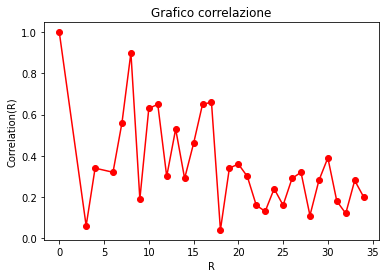

In [11]:
massimo = 35
normalization = correlation(0)

r2 = np.arange(0,massimo,1)
cor = []
r = []
for i in range (r2.size):
    result = correlation(r2[i])
    if result[0] == True:
        cor.append(np.round(result[1],2) / normalization[1])
        r.append(r2[i])
    print(i)
cor=np.array(cor)
r=np.array(r)

plt.plot(r, cor, marker = "o", color = 'red')
plt.title("Grafico correlazione")
plt.xlabel("R") 
plt.ylabel("Correlation(R)")
plt.show()

Rappresentazione volume ad un certo step t

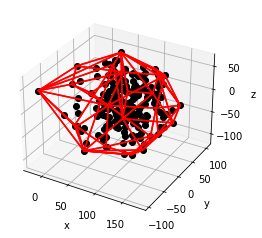

In [12]:
pts=pos_at_step(view_step,file_pos_tot)
hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

Calcolo polarizzazione:
![Polarizzazione](Polarizzazione.png)

In [13]:
print(polarization_at_step(view_step,file_vel_tot))

0.8337729970250902


In [14]:
#Nomalizzo le velocità medie
VelNorm=velMedia/np.linalg.norm(velMedia)

Calcolo l'anisotropia per ogni step:

In [15]:
step=0
ucc=0
anisotropy=np.zeros((steps,birds))
for i in range (steps*birds):
    anisotropy[step][ucc]=anisotropia(vel_at_step(step,file_vel_tot),pos_at_step(step,file_pos_tot))
    ucc+=1
    if ucc==birds:
        ucc=0
        step+=1
        print(step)

KeyboardInterrupt: 

Calcolo modulo velocità media per ogni uccello ad ogni step

In [ ]:
velMod_tot=np.linalg.norm(file_vel_tot, axis=1)
velMod=np.zeros((steps,birds))
t=0
ucc=0
for i in range (velMod_tot.size):
    velMod[t][ucc]=velMod_tot[i]
    ucc+=1
    if ucc==birds:
        ucc=0
        t+=1    

Stampo grafico del modulo della velocità per ogni uccello - ogni step

In [ ]:
max_time=100
view_birds=100

tempo=[]
for j in range (velMod.shape[0]):
    tempo.append(j)
tempo=np.array(tempo)

plt.plot(tempo[0:max_time], velMod[:max_time,:view_birds], marker = "o", color = 'red',linewidth=1, markersize=0.11)
plt.title("Grafico Mod_Vel - Tempo")
plt.xlabel("Tempo") 
plt.ylabel("Modulo Velocità")

plt.show()

In [ ]:
ModVelUcc=np.linalg.norm(vel_at_step(view_step,file_vel_tot),axis=1)
minMod=min(ModVelUcc.reshape(-1,1))
maxMod=max(ModVelUcc.reshape(-1,1))
"""
rang=(maxMod-minMod)/4
Bins=np.zeros(4)
rangValue=np.array((rang,rang*2,rang*3,rang*4))
for i in range (birds):
    velb=ModVelUcc[i]
    if velb < rang:
        Bins[0]+=1
    elif velb < (rang*2):
        Bins[1]+=1
    elif velb < (rang*3):
        Bins[2]+=1
    else:
        Bins[3]+=1
"""

plt.hist(ModVelUcc, bins=50)
plt.xlabel("Modulo Velocità")
plt.ylabel("Conteggio")
plt.title("Histogram")
plt.show()

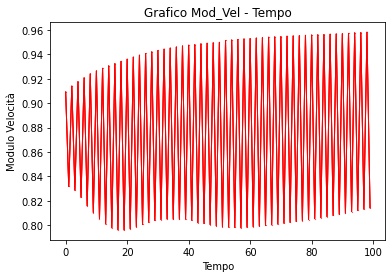

In [16]:
max_time=2000

tempo=[]
for j in range (steps):
    tempo.append(j)
tempo=np.array(tempo)

vel_media_mod_tot = np.zeros((steps, ndim))

for j in range(steps):
    vel_media_mod_tot[j] = np.linalg.norm(vel_media_at_step(j,file_vel_tot))
    

plt.plot(tempo[0:max_time], vel_media_mod_tot[:max_time, :], marker = "o", color = 'red',linewidth=1, markersize=0.11)
plt.title("Grafico Mod_Vel - Tempo")
plt.xlabel("Tempo") 
plt.ylabel("Modulo Velocità")

plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


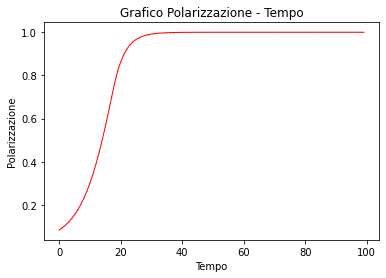

In [62]:
max_time=steps

tempo=[]
for j in range (steps):
    tempo.append(j)
tempo=np.array(tempo)

pol_tot = np.zeros((steps, 1))

for j in range (max_time):
    pol_tot[j] = polarization_at_step(j,file_vel_tot)
    print(j)
    

plt.plot(tempo[0:max_time], pol_tot[:max_time, :], marker = "o", color = 'red',linewidth=1, markersize=0.11)
plt.title("Grafico Polarizzazione - Tempo")
plt.xlabel("Tempo") 
plt.ylabel("Polarizzazione")

plt.show()

In [46]:
vel_step=vel_at_step(view_step,file_vel_tot)

vett_x = vel_step=[:,0]
vett_y = vel_step=[:,1]
vett_z = vel_step=[:,2]

